# Radiocarbon

In this tutorial, we will simulate the radiocarbon age using the AIBECS by
1. defining the transport `T(p)` and the sources and sinks `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated radiocarbon age.

> *Note*
> Although this tutorial is self-contained, it involves non-linearitiess and is slightly more complicated than the first tutorial for simulating the ideal age.
> (So do not hesitate to start with the ideal-age tutorial if you wish.)

The tracer equation for radiocarbon is

$$\big(\partial_t + \mathbf{T} \big) \boldsymbol{R} = \frac{\lambda}{h} (\overline{\boldsymbol{R}}_\mathsf{atm} - \boldsymbol{R}) (\boldsymbol{z} ≤ h) - \boldsymbol{R} / \tau.$$

where the first term on the right of the equal sign represents the air–sea gas exchange with a piston velocity $λ$ over a depth $h$ and the second term represents the radioactive decay of radiocarbon with timescale $\tau$.

> Note:
> We need not specify the value of the atmospheric radiocarbon concentration because it is not important for determining the age of a water parcel — only the relative concentration $\boldsymbol{R}/\overline{\boldsymbol{R}}_\mathsf{atm}$ matters.

We start by selecting the circulation for Radiocarbon

In [1]:
using AIBECS
grd, T_OCIM2 = OCIM2.load()
T(p) = T_OCIM2

┌ Warning: Over-writing registration of the datadep
│   name = AIBECS-OCIM2_CTL_He
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/registration.jl:15
┌ Info: You are about to use the OCIM2_CTL_He model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., & Holzer, M. (2019). Radiocarbon and helium isotope constraints on deep ocean ventilation and mantle‐³He sources. Journal of Geophysical Research: Oceans, 124, 3036–3057. https://doi.org/10.1029/2018JC014716
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Holzer_2019" key.)
└ @ AIBECS.OCIM2 /Users/runner/runners/2.169.1/work/AIBECS.jl/AIBECS.jl/src/OCIM2.jl:113


T (generic function with 1 method)

The local sources and sinks are simply given by

In [2]:
function G(R,p)
    @unpack λ, h, R̅atm, τ = p
    return @. λ / h * (R̅atm - R) * (z ≤ h) - R / τ
end

G (generic function with 1 method)

We can define `z` via

In [3]:
z = depthvec(grd)

200160-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

In this tutorial we will specify some units for the parameters.
Such features **must** be imported to be used

In [4]:
import AIBECS: @units, units

We define the parameters using the dedicated API from the AIBECS, including keyword arguments and units this time

In [5]:
@units struct RadiocarbonParameters{U} <: AbstractParameters{U}
    λ::U    | u"m/yr"
    h::U    | u"m"
    τ::U    | u"yr"
    R̅atm::U | u"M"
end

units (generic function with 20 methods)

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.

In [6]:
p = RadiocarbonParameters(λ = 50u"m"/10u"yr",
                          h = grd.δdepth[1],
                          τ = 5730u"yr"/log(2),
                          R̅atm = 42.0u"nM")


│ Row │ Symbol │ Value   │ Unit     │
│     │ Symbol │ Float64 │ Unitful… │
├─────┼────────┼─────────┼──────────┤
│ 1   │ λ      │ 5.0     │ m yr⁻¹   │
│ 2   │ h      │ 36.1351 │ m        │
│ 3   │ τ      │ 8266.64 │ yr       │
│ 4   │ R̅atm   │ 4.2e-8  │ M        │

> *Note*
> The parameters are converted to SI units when unpacked.
>  When you specify units for your parameters, you must supply their values in that unit.

We generate the state function and its Jacobian, generate the corresponding steady-state problem, and solve it, via

In [7]:
F, ∇ₓF = state_function_and_Jacobian(T, G)
x = zeros(length(z)) # an initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)
R = solve(prob, CTKAlg()).u

200160-element Array{Float64,1}:
 3.5560535238217556e-5
 3.5562770568747024e-5
 3.5501074995053995e-5
 3.552338765730103e-5
 3.5824950925199526e-5
 3.592509725692046e-5
 3.581202090506593e-5
 3.589200096627801e-5
 3.6058151597816365e-5
 3.628098578396294e-5
 ⋮
 3.6514370901105506e-5
 3.6601124933316816e-5
 3.617455107083526e-5
 3.632073919385803e-5
 3.6554816317834214e-5
 3.673436464054447e-5
 3.6255123856080256e-5
 3.626845589256729e-5
 3.6524638793500936e-5

This should take a few seconds on a laptop.
Once the radiocarbon concentration is computed, we can convert it into the corresponding age in years, via

In [8]:
@unpack τ, R̅atm = p
C14age = @. log(R̅atm / R) * τ * u"s" |> u"yr"

200160-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
 1375.8434153036123 yr
  1375.323791578553 yr
 1389.6775147930339 yr
 1384.4835068954687 yr
  1314.602956155404 yr
 1291.5263314268468 yr
 1317.5871095466482 yr
 1299.1455539168726 yr
 1260.9660566230673 yr
 1210.0366022328935 yr
                     ⋮
 1157.0299807644064 yr
 1137.4126642049152 yr
 1234.3234518803556 yr
 1200.9837246586314 yr
  1147.878439570612 yr
  1107.374104265437 yr
  1215.931357947444 yr
 1212.8920379860606 yr
 1154.7057160340632 yr

and plot it at 700 m using the `horizontalslice` Plots recipe

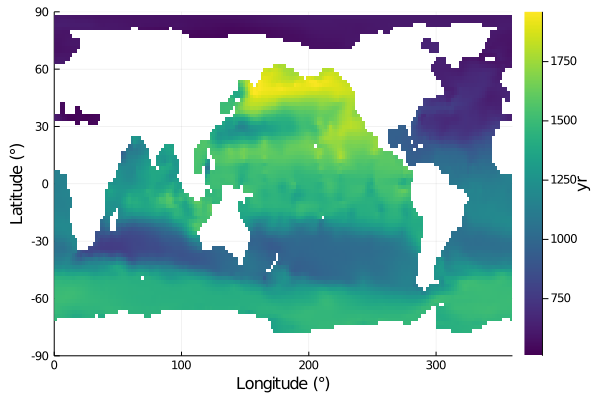

In [9]:
using Plots
horizontalslice(C14age, grd, depth=700u"m", color=:viridis)

look at a zonal average using the `zonalaverage` plot recipe

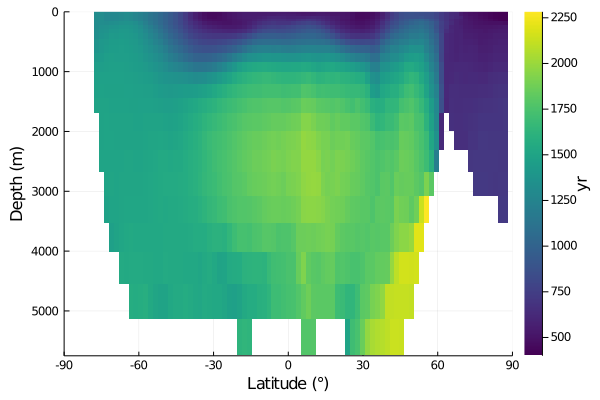

In [10]:
zonalaverage(C14age, grd; color=:viridis)

or look at a meridional slice through the Atlantic at 30°W using the `meridionalslice` plot recipe

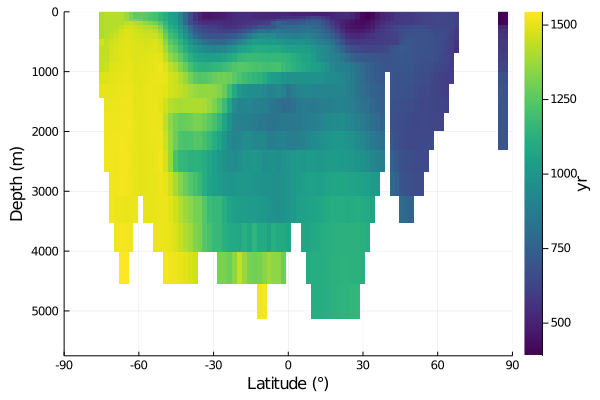

In [11]:
meridionalslice(C14age, grd, lon=-30, color=:viridis)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*